In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

import tensorflow as tf
from tensorflow import keras

keras.utils.set_random_seed(42)

In [2]:
# install transformer package
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 15.5 MB/s 
     |████████████████████████████████| 182 kB 75.9 MB/s 
     |████████████████████████████████| 7.6 MB 62.0 MB/s 


In [3]:
from transformers import BertTokenizer

In [4]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b3176a10-473d-65db-0e46-70b44e71121b)


In [5]:
df = pd.read_csv('https://www.dropbox.com/s/bftxg089s8bx86f/Financial%20Sentiment%20Data.csv?dl=1')

In [6]:
train_X, test_X, train_y, test_y = train_test_split(df['Sentence'], df['Sentiment'], test_size=0.25, random_state=42, stratify=df['Sentiment'])

In [7]:
n_neu = train_y.value_counts()['neutral']
n_pos = train_y.value_counts()['positive']
n_neg = train_y.value_counts()['negative']

train_y.value_counts()

neutral     2347
positive    1389
negative     645
Name: Sentiment, dtype: int64

In [8]:
# balance data -> upsample minority class
train = pd.concat([train_X, train_y], axis=1)
train_pos = pd.concat([train[train.Sentiment=='positive'], 
                      train[train.Sentiment=='positive'].sample(n=(n_neu-n_pos), replace=True, random_state=42)])
train_neg = pd.concat([train[train.Sentiment=='negative'],
                       train[train.Sentiment=='negative'].sample(n=(n_neu-n_neg), replace=True, random_state=42)])
train_balanced = pd.concat([train_pos, train_neg, train[train.Sentiment=='neutral']])
train_X, train_y = train_balanced['Sentence'], train_balanced['Sentiment']

train_y.value_counts()

positive    2347
negative    2347
neutral     2347
Name: Sentiment, dtype: int64

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
max_query_length = 100

In [11]:
# tokenize both the training set and the test set
source_train = tokenizer(train_X.values.tolist(), max_length=max_query_length, return_tensors='tf', truncation=True, padding='max_length')
source_test = tokenizer(test_X.values.tolist(), max_length=max_query_length, return_tensors='tf', truncation=True, padding='max_length')

In [12]:
# tokenize labels
text_vectorization_label = keras.layers.TextVectorization()
text_vectorization_label.adapt(train_y.astype(str))
num_labels = text_vectorization_label.vocabulary_size()

label_train = text_vectorization_label(train_y.astype(str))
label_test = text_vectorization_label(test_y.astype(str))

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
fine_tuned = keras.models.load_model('/content/drive/MyDrive/content/drive/MyDrive/ANLY-580/final_project/fine_tuned_bert_1')

In [26]:
# Get input
new_input = fine_tuned.input
# Find the layer to connect
hidden_layer = fine_tuned.layers[-2].output['pooler_output']
# Connect a new layer on it
x = keras.layers.Dense(256, activation='relu')(hidden_layer)
# x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)
new_output = keras.layers.Dense(num_labels, activation="softmax")(x)
# Build a new model
model = keras.Model(inputs=new_input, outputs=new_output)

for layer in model.layers[:-4]:
  layer.trainable = False
for layer in model.layers[-4:]:
  layer.trainable = True

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 bert (Custom>TFBertMainLayer)  {'pooler_output': (  108310272   ['input_ids[0][0]',              
                                None, 768),                       'token_type_ids[0][0]',     

In [27]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])

In [28]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [29]:
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.00005)

In [30]:
BATCH_SIZE = 64
epochs = 100

# Fit
history = model.fit([source_train['input_ids'], source_train['token_type_ids'], source_train['attention_mask']], label_train,
                    batch_size=BATCH_SIZE,
                    validation_data=([source_test['input_ids'], source_test['token_type_ids'], source_test['attention_mask']], label_test),
                    epochs=epochs)

Epoch 1/100
111/111 [==============================] - 66s 504ms/step - loss: 1.1185 - sparse_categorical_accuracy: 0.5006 - val_loss: 1.0214 - val_sparse_categorical_accuracy: 0.4394
Epoch 2/100
111/111 [==============================] - 57s 515ms/step - loss: 0.9341 - sparse_categorical_accuracy: 0.5667 - val_loss: 1.0304 - val_sparse_categorical_accuracy: 0.3860
Epoch 3/100
111/111 [==============================] - 56s 510ms/step - loss: 0.9016 - sparse_categorical_accuracy: 0.5871 - val_loss: 0.9857 - val_sparse_categorical_accuracy: 0.5305
Epoch 4/100
111/111 [==============================] - 57s 513ms/step - loss: 0.8868 - sparse_categorical_accuracy: 0.6049 - val_loss: 0.9678 - val_sparse_categorical_accuracy: 0.4956
Epoch 5/100
111/111 [==============================] - 57s 512ms/step - loss: 0.8654 - sparse_categorical_accuracy: 0.6150 - val_loss: 0.9084 - val_sparse_categorical_accuracy: 0.5681
Epoch 6/100
111/111 [==============================] - 57s 516ms/step - loss: 0.

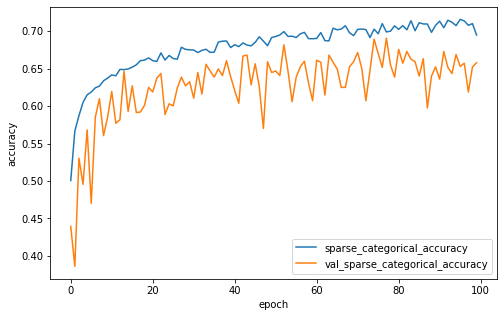

In [31]:
pd.DataFrame(history.history)[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot(figsize=(8,5))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

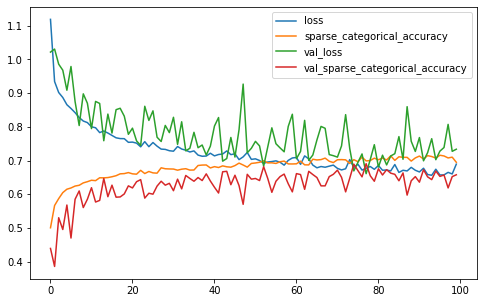

In [32]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

46/46 [==============================] - 11s 212ms/step


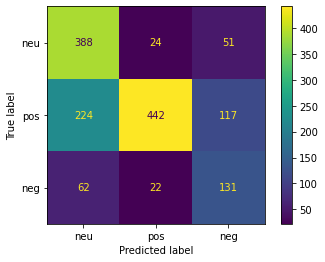

In [33]:
pred = np.argmax(model.predict(x=[source_test['input_ids'], source_test['token_type_ids'], source_test['attention_mask']]),axis=1)

disp = ConfusionMatrixDisplay(confusion_matrix(tf.squeeze(label_test), pred, labels=[2,3,4]),
                       display_labels=['neu','pos','neg'])
disp.plot()
plt.show()

In [34]:
f1_score(tf.squeeze(label_test), pred, average='weighted')

0.6640495788095255